# Rolling window features
22 March 2024   
Conda environment: `time-series`

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from feature_engine.timeseries.forecasting import WindowFeatures
from sktime.transformations.series.summarize import WindowSummarizer

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

Let's create a function to compute the median absolute deviation which is defined as: $MAD = median(|x_i - median(x)|)$

In [3]:
# Functions
def mad(x):
    """Compute the median absolute deviation: MAD
    Args:
        x: input value
    Returns: mad
    """
    return np.median(np.abs(x - np.median(x)))

## 1) Input data

In [4]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)
# Use a subset of the data
data = data.loc["2010":]

data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500


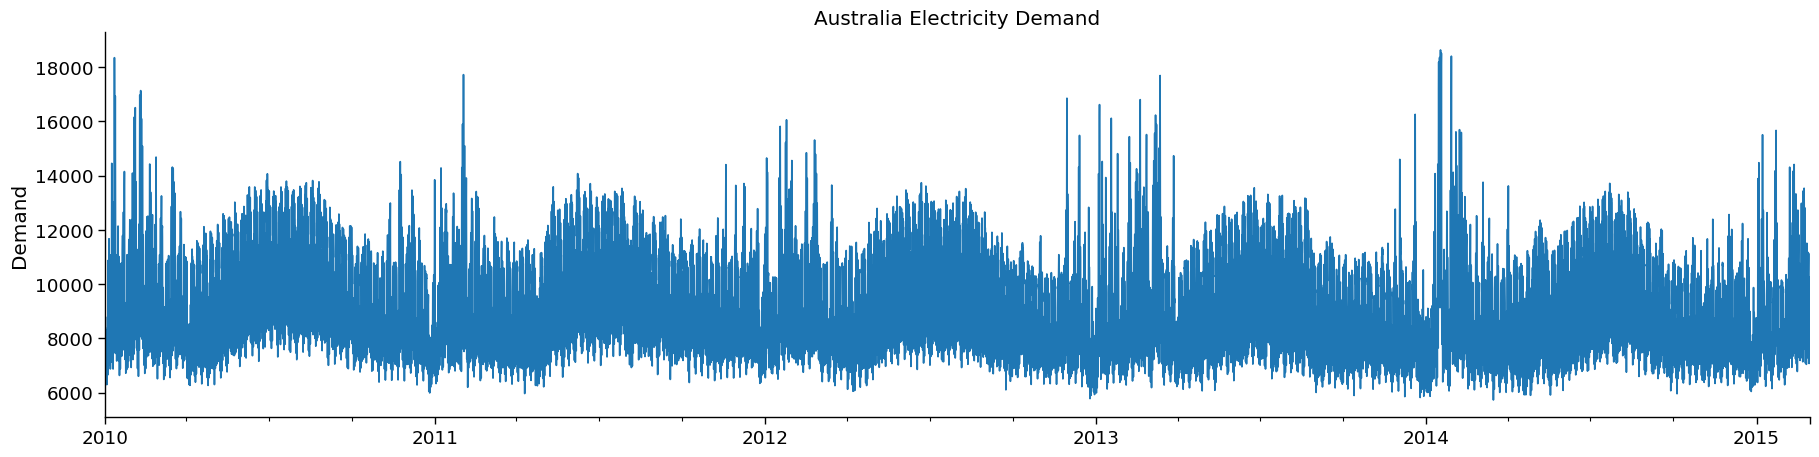

In [5]:
data["demand"].plot()

plt.title("Australia Electricity Demand")
plt.ylabel("Demand")
plt.xlabel("")
plt.show()

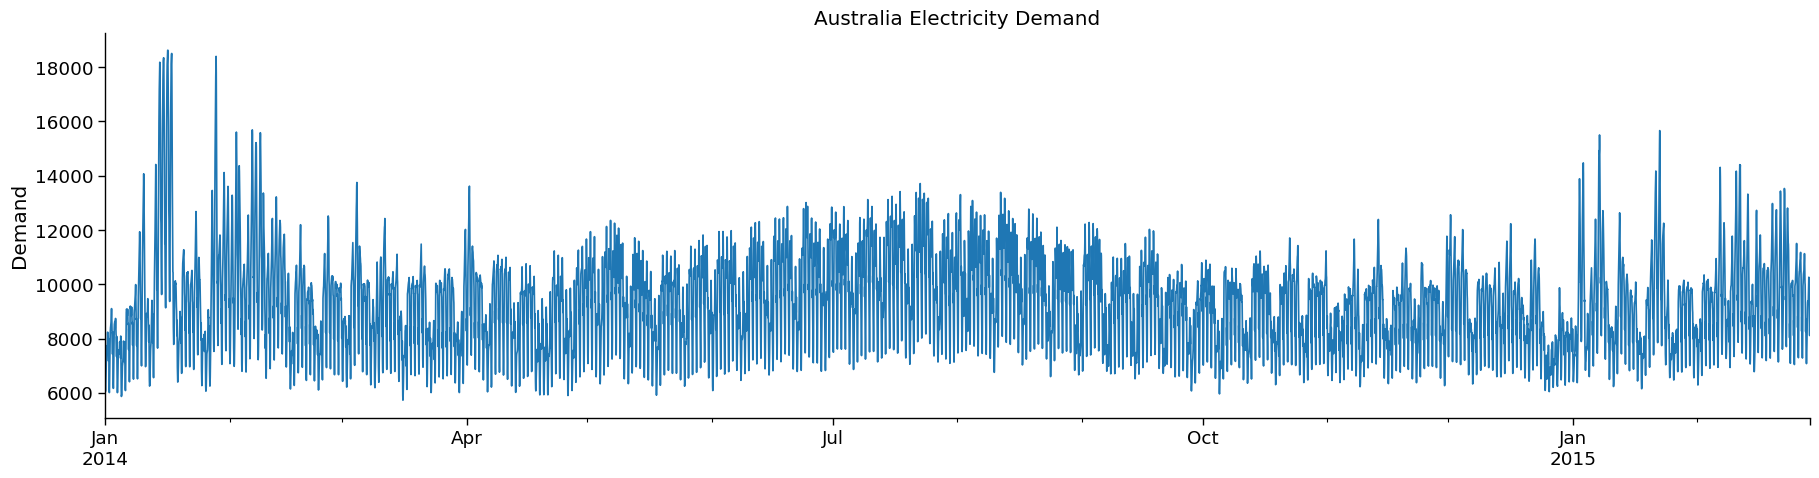

In [6]:
data["demand"].loc["2014":].plot()

plt.title("Australia Electricity Demand")
plt.ylabel("Demand")
plt.xlabel("")
plt.show()

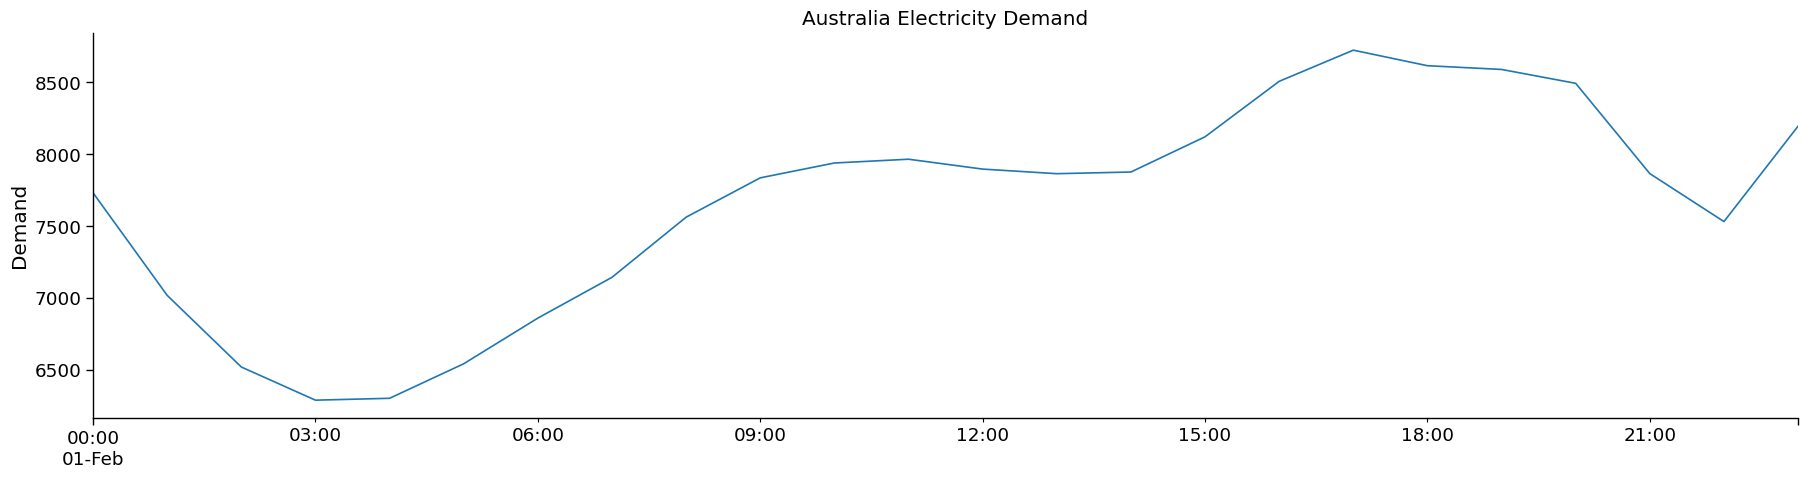

In [7]:
# Demand on a single day
data["demand"].loc["2015-02-01"].plot()

plt.title("Australia Electricity Demand")
plt.ylabel("Demand")
plt.xlabel("")
plt.show()

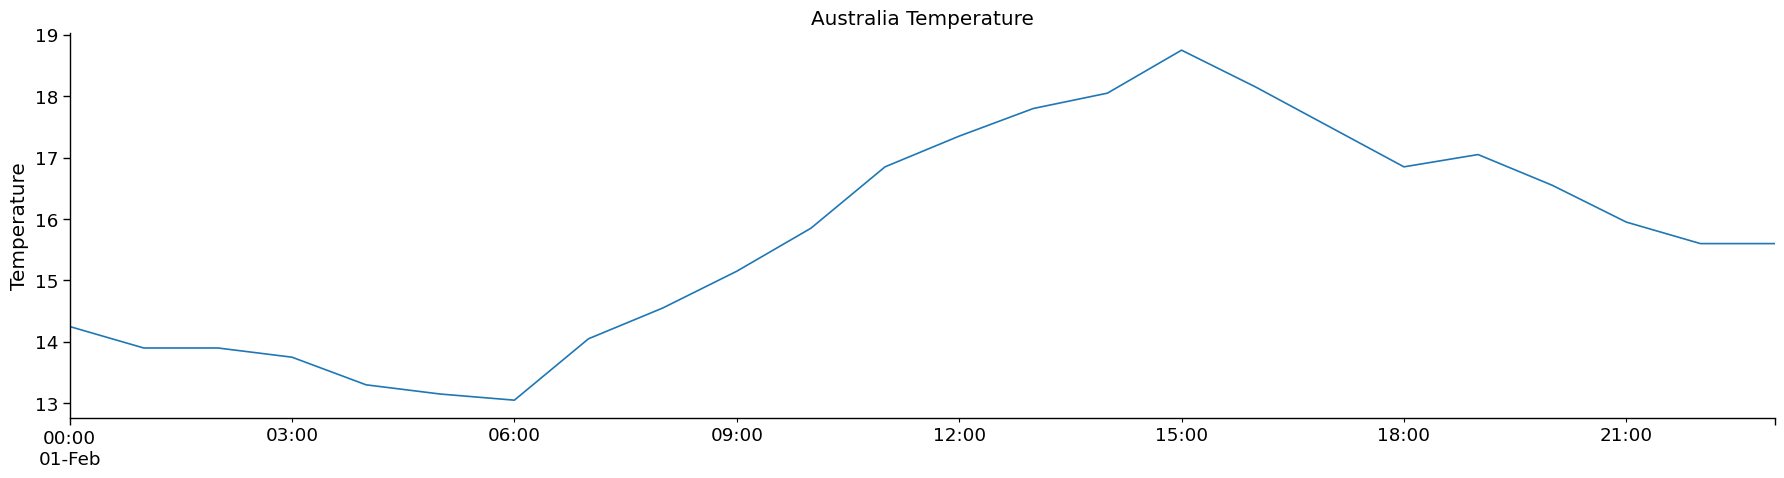

In [8]:
# Temperature on a single day
data["temperature"].loc["2015-02-01"].plot()

plt.title("Australia Temperature")
plt.ylabel("Temperature")
plt.xlabel("")
plt.show()

In [9]:
df = data.copy(deep=True)
df.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500


## 2) Rolling window features

### 2.1) Pandas: rolling window features
Window size of 24h to smooth over daily seasonality.

In [10]:
WINDOW_SIZE = 24

result = (
    df["demand"]
    .rolling(window=WINDOW_SIZE)
    .agg(["mean", "std", mad])
    .shift(freq="1h") # Lag by 1 hour to avoid data leakage
).add_prefix("demand_window_24_")

result

,demand_window_24_mean,demand_window_24_std,demand_window_24_mad
date_time,,,
2010-01-01 01:00:00,NaN,NaN,NaN
2010-01-01 02:00:00,NaN,NaN,NaN
2010-01-01 03:00:00,NaN,NaN,NaN
2010-01-01 04:00:00,NaN,NaN,NaN
2010-01-01 05:00:00,NaN,NaN,NaN
...,...,...,...
2015-02-28 20:00:00,"8,786.5936",957.6157,621.1109
2015-02-28 21:00:00,"8,764.5667",948.6457,655.4532
2015-02-28 22:00:00,"8,750.6813",952.7718,655.4532


In [11]:
df = df.join(result, how="left")
df.head(25)

,demand,temperature,demand_window_24_mean,demand_window_24_std,demand_window_24_mad
date_time,,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,NaN,NaN,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,NaN,NaN,NaN
2010-01-01 03:00:00,"6,952.0475",21.8000,NaN,NaN,NaN
2010-01-01 04:00:00,"6,867.1996",20.2500,NaN,NaN,NaN
2010-01-01 05:00:00,"6,899.8315",20.0250,NaN,NaN,NaN
2010-01-01 06:00:00,"7,217.3389",19.7250,NaN,NaN,NaN
2010-01-01 07:00:00,"7,432.7308",19.4500,NaN,NaN,NaN
2010-01-01 08:00:00,"7,714.8005",19.2750,NaN,NaN,NaN


#### 2.1.1) min periods
The `min_periods` argument can be used to allow smaller window sizes to be applied at the start of the time series.

In [24]:
WINDOW_SIZE = 24

result = (
    df["demand"]
    .rolling(window=WINDOW_SIZE, min_periods=1) # min periods to allow smaller window sizes at the start of the ts
    .agg(["mean", "std", mad])
    .shift(freq="1h") # Lag by 1 hour to avoid data leakage
).add_prefix("demand_window_24_")

pd.merge(left=df["demand"].to_frame(), right=result, left_index=True, right_index=True, how="left")

,demand,demand_window_24_mean,demand_window_24_std,demand_window_24_mad
date_time,,,,
2010-01-01 00:00:00,"8,314.4487",NaN,NaN,NaN
2010-01-01 01:00:00,"8,267.1873","8,314.4487",NaN,0.0000
2010-01-01 02:00:00,"7,394.5284","8,290.8180",33.4188,23.6307
2010-01-01 03:00:00,"6,952.0475","7,992.0548",518.0123,47.2614
2010-01-01 04:00:00,"6,867.1996","7,732.0530",670.2947,459.9601
...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771","8,802.5657",974.7597,712.8573
2015-02-28 20:00:00,"8,883.2303","8,786.5936",957.6157,621.1109
2015-02-28 21:00:00,"8,320.2605","8,764.5667",948.6457,655.4532


### 2.2) Feature engine: rolling window features

In [25]:
# Create a copy of the data.
df = data.copy(deep=True)

In [29]:
# Create window features using the transformer.
transformer = WindowFeatures(
    variables=["demand", "temperature"],
    functions=["mean", "std"],
    window=[24, 24 * 7, 24 * 365], # Day, week, year.
    freq="1H",
)

df = transformer.fit_transform(df)
df

,demand,temperature,demand_window_24_mean,demand_window_24_std,temperature_window_24_mean,temperature_window_24_std,demand_window_168_mean,demand_window_168_std,temperature_window_168_mean,temperature_window_168_std,demand_window_8760_mean,demand_window_8760_std,temperature_window_8760_mean,temperature_window_8760_std
date_time,,,,,,,,,,,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 03:00:00,"6,952.0475",21.8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 04:00:00,"6,867.1996",20.2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"8,802.5657",974.7597,21.8563,5.1417,"9,670.4635","1,539.9929",21.0857,4.8404,"9,169.1302","1,597.8450",16.2793,5.2721
2015-02-28 20:00:00,"8,883.2303",22.2000,"8,786.5936",957.6157,22.2167,5.2851,"9,654.6168","1,526.8382",21.0690,4.8102,"9,169.1434","1,597.8481",16.2803,5.2735
2015-02-28 21:00:00,"8,320.2605",18.9000,"8,764.5667",948.6457,22.3604,5.2334,"9,638.0186","1,519.9200",21.0318,4.7768,"9,169.1225","1,597.8506",16.2807,5.2738


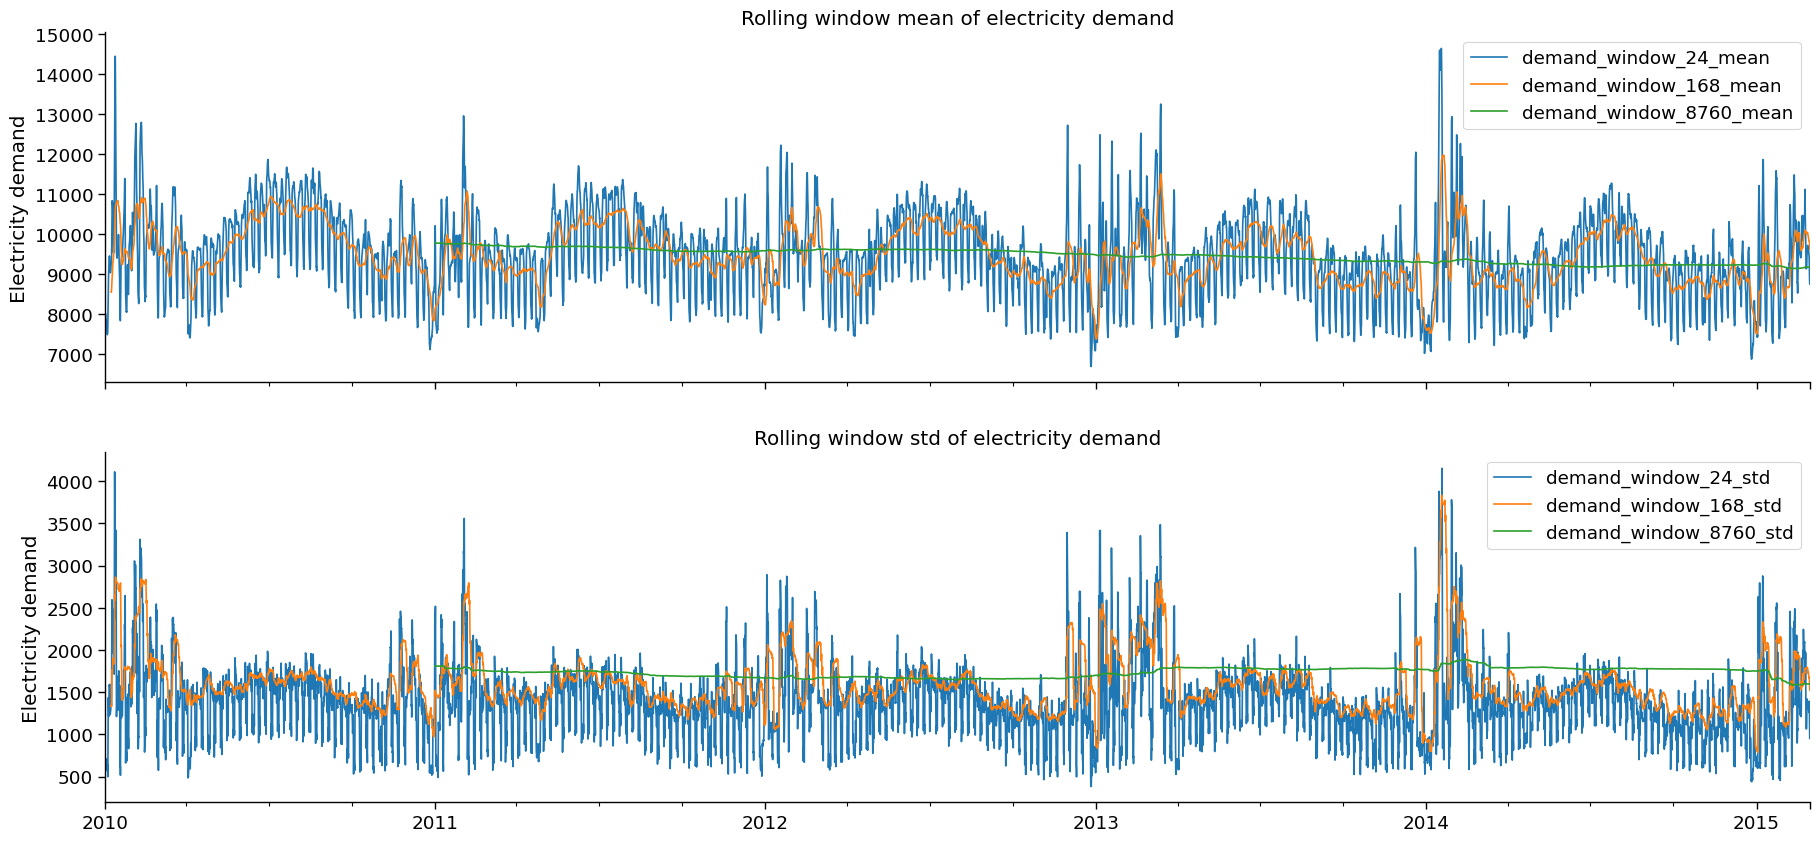

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(22,10), sharex=True)

mean_plot = df.filter(
    regex="demand_.*?_mean", # `.*?` means any number of any characters.
    axis=1  # Filter by column names.
).plot(ax=ax[0])

std_plot = df.filter(
    regex="demand_.*?_std", 
    axis=1  # Filter by column names.
).plot(ax=ax[1])

mean_plot.set_title("Rolling window mean of electricity demand")
mean_plot.set_ylabel("Electricity demand")
mean_plot.set_xlabel("")

std_plot.set_title("Rolling window std of electricity demand")
std_plot.set_ylabel("Electricity demand")
std_plot.set_xlabel("")

plt.show()

### 2.3) sktime: rolling window features

In [44]:
df = data.copy(deep=True)

In [46]:
transformer = WindowSummarizer(
    lag_feature={
        "lag":  [1, 2, 3],  # Lag features.
        "mean": [[1, 24], [1, 24*7], [1, 24*365]],  # [[lag/shift, window size]]
        "std":  [[1, 24], [1, 24*7], [1, 24*365]],
        mad:    [[1, 24], [1, 24*7], [1, 24*365]],  
    },
    target_cols=["demand"],
)

result = transformer.fit_transform(df)
result

,demand_lag_1,demand_lag_2,demand_lag_3,demand_mean_1_24,demand_mean_1_168,demand_mean_1_8760,demand_std_1_24,demand_std_1_168,demand_std_1_8760,demand_mad_1_24,demand_mad_1_168,demand_mad_1_8760,temperature
date_time,,,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5250
2010-01-01 01:00:00,"8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.4000
2010-01-01 02:00:00,"8,267.1873","8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.1500
2010-01-01 03:00:00,"7,394.5284","8,267.1873","8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.8000
2010-01-01 04:00:00,"6,952.0475","7,394.5284","8,267.1873",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,979.9099","10,258.5854","10,019.9216","8,802.5657","9,670.4635","9,169.1302",974.7597,"1,539.9929","1,597.8450",712.8573,"1,109.9962","1,203.7507",28.3500
2015-02-28 20:00:00,"9,596.7771","9,979.9099","10,258.5854","8,786.5936","9,654.6168","9,169.1434",957.6157,"1,526.8382","1,597.8481",621.1109,"1,089.0488","1,203.7507",22.2000
2015-02-28 21:00:00,"8,883.2303","9,596.7771","9,979.9099","8,764.5667","9,638.0186","9,169.1225",948.6457,"1,519.9200","1,597.8506",655.4532,"1,076.7206","1,203.7507",18.9000


In [47]:
df = result.join(df["demand"], how="left")
df

,demand_lag_1,demand_lag_2,demand_lag_3,demand_mean_1_24,demand_mean_1_168,demand_mean_1_8760,demand_std_1_24,demand_std_1_168,demand_std_1_8760,demand_mad_1_24,demand_mad_1_168,demand_mad_1_8760,temperature,demand
date_time,,,,,,,,,,,,,,
2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5250,"8,314.4487"
2010-01-01 01:00:00,"8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.4000,"8,267.1873"
2010-01-01 02:00:00,"8,267.1873","8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.1500,"7,394.5284"
2010-01-01 03:00:00,"7,394.5284","8,267.1873","8,314.4487",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.8000,"6,952.0475"
2010-01-01 04:00:00,"6,952.0475","7,394.5284","8,267.1873",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2500,"6,867.1996"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-28 19:00:00,"9,979.9099","10,258.5854","10,019.9216","8,802.5657","9,670.4635","9,169.1302",974.7597,"1,539.9929","1,597.8450",712.8573,"1,109.9962","1,203.7507",28.3500,"9,596.7771"
2015-02-28 20:00:00,"9,596.7771","9,979.9099","10,258.5854","8,786.5936","9,654.6168","9,169.1434",957.6157,"1,526.8382","1,597.8481",621.1109,"1,089.0488","1,203.7507",22.2000,"8,883.2303"
2015-02-28 21:00:00,"8,883.2303","9,596.7771","9,979.9099","8,764.5667","9,638.0186","9,169.1225",948.6457,"1,519.9200","1,597.8506",655.4532,"1,076.7206","1,203.7507",18.9000,"8,320.2605"
